In [1]:
from pygeoinf.interval import Lebesgue, InverseLaplacian, Laplacian, IntervalDomain, BoundaryConditions, Function, BesselSobolev, BesselSobolevInverse
from pygeoinf import MassWeightedHilbertSpace
from pygeoinf.interval.fast_bessel_operators import FastBesselSobolev, FastBesselSobolevInverse
import numpy as np
import matplotlib.pyplot as plt
from pygeoinf.interval.function_providers import BumpFunctionProvider, BumpFunctionGradientProvider

In [2]:
f_domain = IntervalDomain(0, 1)
bcs = BoundaryConditions('dirichlet')
l2space = Lebesgue(1, f_domain, basis=None)
lap = Laplacian(l2space, bcs, method='finite_difference', dofs=500)
inv_lap = InverseLaplacian(l2space, bcs)

In [3]:
f = BumpFunctionGradientProvider(l2space, default_width=0.5, centers=[0.5]).get_function_by_index(0)
x = f_domain.uniform_mesh(1000)

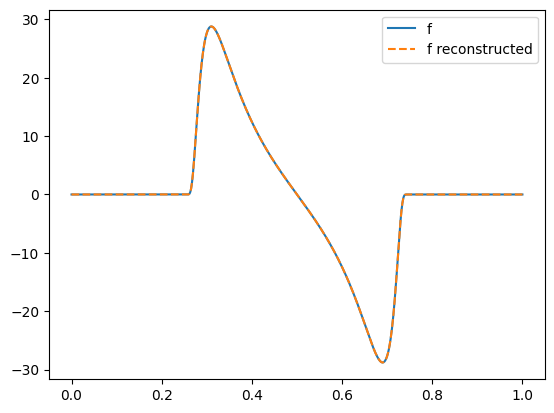

In [10]:
BSO = FastBesselSobolev(l2space, l2space, k=1.0, s=1.0, L=lap, dofs=500)
BSOI = FastBesselSobolevInverse(l2space, l2space, k=1.0, s=1.0, L=lap, dofs=500)
#plt.plot(x, BSO(f)(x), label='BSO(f)', linestyle='--')
plt.plot(x, f(x), label='f')
plt.plot(x, BSO(BSOI(f))(x), label='f reconstructed', linestyle='--')
plt.legend()

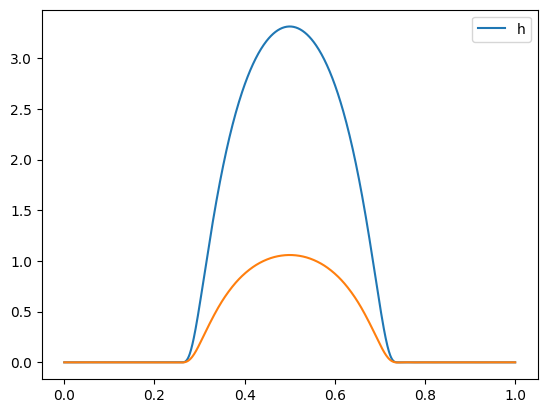

In [5]:


bcs2 = BoundaryConditions(bc_type='dirichlet')
L = Laplacian(l2space, bcs2, method='finite_difference', dofs=1000)
BSOI2 = BesselSobolevInverse(l2space, l2space, k=300.0, s=0.1, L=lap, dofs=50)

h = BumpFunctionProvider(l2space, default_width=0.5, centers=[0.5]).get_function_by_index(0)

plt.plot(x, h(x), label='h')
plt.plot(x, BSOI2(h)(x))
plt.legend()